# This code is used to generate text classification for covid tweets using Natural Language Processing.

The dataset used here is the publically available data from Kaggle. You can download the data using the below link.
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

Link to code examlpe in github.
https://github.com/utkarshx27/Kaggle-Work-ML-Models/blob/6bb5faee1af9bd5ae5adb0c911adcecd6aab7de3/covid-tweet-classification-nb-vs-lstm.ipynb

### The various tasks are as follows:
1. Exploratory Data Analysis
2. Data pre-processing
3. Data Modeling (with Training/Test Data)
4. Classification of covid tweets (Naive Bayes algorithm vs. LSTM)

In [1]:
pip install seaborn 

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [4]:
df_test = pd.read_csv("C:\\Users\\danielle.koduru\\Covid Tweets Dataset\\Corona_NLP_test.csv", encoding='latin-1')
df_test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
df_train = pd.read_csv("C:\\Users\\danielle.koduru\\Covid Tweets Dataset\\Corona_NLP_train.csv", encoding='latin-1')
df_train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [6]:
df_train.columns

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [7]:
df_test.columns 

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')

In [8]:
df_train = df_train.loc[:, ['OriginalTweet', 'Sentiment']]
df_train = df_train.rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'emotion'})
df_test = df_test.loc[:, ['OriginalTweet', 'Sentiment']]
df_test = df_test.rename(columns={'OriginalTweet': 'tweet', 'Sentiment': 'emotion'})

#1. Exploratory Data Analysis (EDA)

In [9]:
sen_tweet = df_train['emotion'].value_counts().reset_index()
sen_tweet

,emotion,count
0,Positive,11422
1,Negative,9917
2,Neutral,7713
3,Extremely Positive,6624
4,Extremely Negative,5481


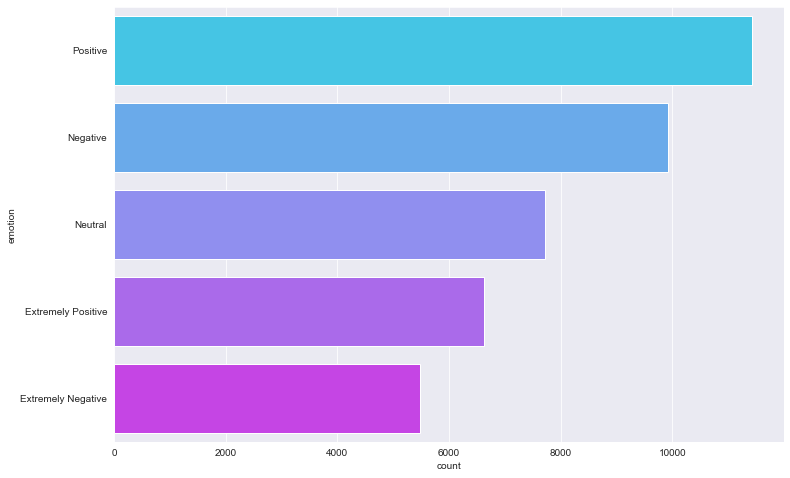

In [10]:
plt.figure(figsize=(12,8))
sns.barplot(x=sen_tweet['count'], y=sen_tweet['emotion'], palette='cool')
plt.show()

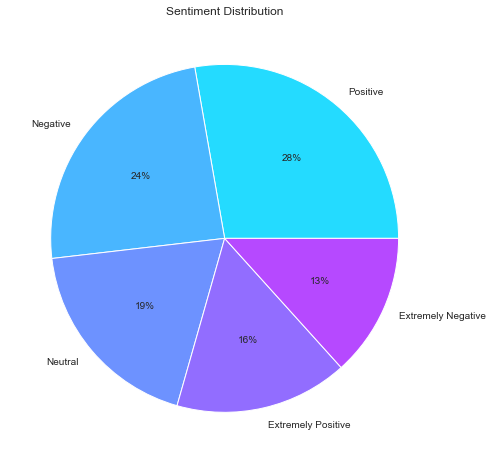

In [11]:
plt.figure(figsize=(12,8))
plt.pie(sen_tweet['count'], labels=sen_tweet['emotion'],
        colors=sns.color_palette('cool'), autopct='%.0f%%')
plt.title('Sentiment Distribution')
plt.show()

In [25]:
sen_tweet_test = df_test['emotion'].value_counts().reset_index()
sen_tweet_test

,emotion,count
0,Negative,1041
1,Positive,947
2,Neutral,619
3,Extremely Positive,599
4,Extremely Negative,592


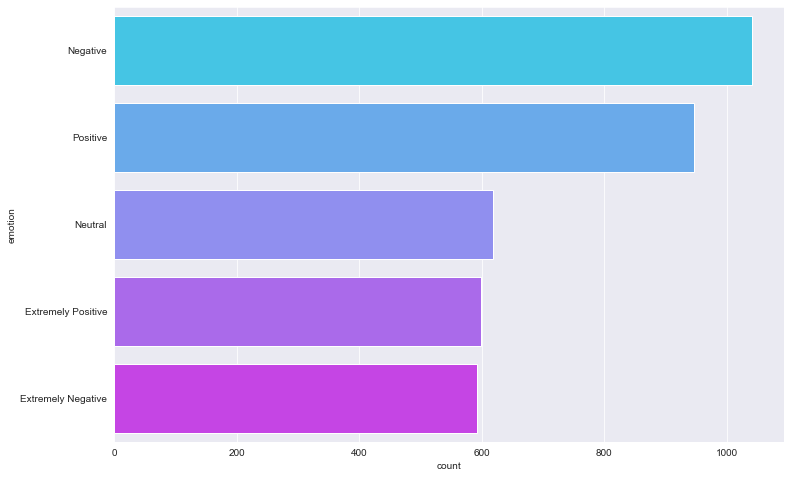

In [26]:
plt.figure(figsize=(12,8))
sns.barplot(x=sen_tweet_test['count'], y=sen_tweet_test['emotion'], palette='cool')
plt.show()

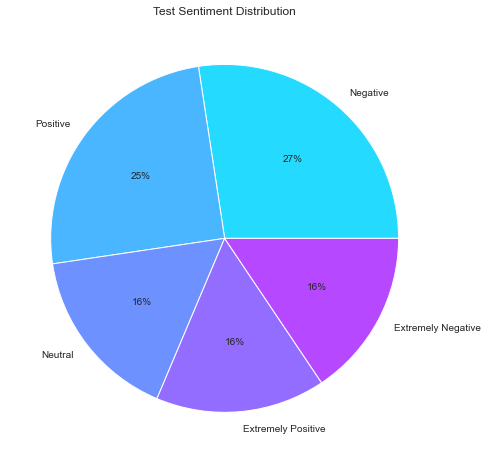

In [27]:
plt.figure(figsize=(12,8))
plt.pie(sen_tweet_test['count'], labels=sen_tweet_test['emotion'],
        colors=sns.color_palette('cool'), autopct='%.0f%%')
plt.title('Test Sentiment Distribution')
plt.show()

#2. Data Pre-processing:

1. Data Cleaning
2. Data Encoding

In [13]:
#Cleaning all data - removing unneeded tgas, characters, etc
def cleaning(data):
    df = data.copy()
    df.columns = map(str.lower, df.columns)
    df = df[['tweet', 'emotion']]
        
    def remove_web_urls(text): return re.sub(r'https?://\S+', ' ', text)
    df['tweet'] = df['tweet'].apply(remove_web_urls) #remove web urls

    def remove_tags(text): return re.sub(r'@\w*', ' ' , text)
    df['tweet'] = df['tweet'].apply(remove_tags)#remove tags

    def remove_hashtags(text): return re.sub(r'#\w*', ' ' , text)
    df['tweet'] = df['tweet'].apply(remove_hashtags)#remove hashtags

    def remove_apostrophe(text): return re.sub(r"'s\b", "", text)
    df['tweet'] = df['tweet'].apply(remove_apostrophe)#remove apostrophe

    def remove_special_chars(text): return re.sub(r"[^a-zA-Z0-9\s]", ' ', text)
    df['tweet'] = df['tweet'].apply(remove_special_chars)#remove special characters

    def remove_number(text): return re.sub(r'[\d]', ' ', text)
    df['tweet'] = df['tweet'].apply(remove_number)#remove numbers 

    df['tweet'] = df['tweet'].str.lower()
    return df
cleaned_train = cleaning(df_train)
cleaned_test = cleaning(df_test)

In [14]:
cleaned_train.shape, cleaned_test.shape

((41157, 2), (3798, 2))

In [15]:
df_train['emotion'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [16]:
cleaned_train["emotion"].value_counts()

emotion
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [18]:
cleaned_train['emotion'] = cleaned_train['emotion'].str.replace('Extremely Positive', 'Positive')
cleaned_train['emotion'] = cleaned_train['emotion'].str.replace('Extremely Negative', 'Negative')

cleaned_test['emotion'] = cleaned_test['emotion'].str.replace('Extremely Positive', 'Positive')
cleaned_test['emotion'] = cleaned_test['emotion'].str.replace('Extremely Negative', 'Negative')

In [19]:
cleaned_train["emotion"].value_counts(), cleaned_test["emotion"].value_counts()

(emotion
 Positive    18046
 Negative    15398
 Neutral      7713
 Name: count, dtype: int64,
 emotion
 Negative    1633
 Positive    1546
 Neutral      619
 Name: count, dtype: int64)

In [20]:
X = cleaned_train['tweet']
y = cleaned_train['emotion']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32925,), (8232,), (32925,), (8232,))

In [22]:
# mapping words and phrases to corresponding vector of real numbers 
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_val_vectorized = vectorizer.transform(X_val)

In [23]:
#Naive Bayes algorithm 
model = MultinomialNB()
model.fit(X_train_vectorized, y_train)
y_pred = model.predict(X_val_vectorized)

accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6922983479105929


In [24]:
#splits sequences into smaller units so to be more easily understood
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

#limiting transformer model to a mx sequence length of 100
max_sequence_length = 100 
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length)

#converting all categorical variables into numerical format 
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

#transforms high-dimensional categorical data into dense fixed size vector that's easier for the model to interpret
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))  

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# A method to perform synchronous distributed training across multiple GPUs - creates replicas to be mirrored across GPUs
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    mirrored_model = model


mirrored_model.fit(X_train_padded, y_train_encoded, validation_data=(X_val_padded, y_val_encoded), epochs=5, batch_size=32)


y_pred_probs = mirrored_model.predict(X_val_padded)
y_pred_encoded = tf.argmax(y_pred_probs, axis=1).numpy()


y_pred_labels = label_encoder.inverse_transform(y_pred_encoded)

#Accuracy of model
accuracy = accuracy_score(y_val, y_pred_labels)
print("Accuracy:", accuracy)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Epoch 1/5
1029/1029 [==============================] - 143s 137ms/step - loss: 0.6808 - accuracy: 0.6973 - val_loss: 0.4197 - val_accuracy: 0.8558
Epoch 2/5
1029/1029 [==============================] - 181s 176ms/step - loss: 0.2843 - accuracy: 0.9073 - val_loss: 0.3632 - val_accuracy: 0.8797
Epoch 3/5
1029/1029 [==============================] - 138s 134ms/step - loss: 0.1726 - accuracy: 0.9441 - val_loss: 0.3997 - val_accuracy: 0.8831
Epoch 4/5
1029/1029 [==============================] - 148s 144ms/step - loss: 0.1058 - accuracy: 0.9654 - val_loss: 0.4065 - val_accuracy: 0.8816
Epoch 5/5
258/258 [==============================] - 9s 33ms/step
Accuracy: 0.8764577259475219
